In [2]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

#from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, search_around
from cuts import getGeoCuts
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
pathdir = os.path.abspath(os.getcwd())+'/LG_dr8_example'
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)

## Load Large Galaxies from SWEEPS in DR8
Get the large galaxies from maskbitsources catalogue 

In [4]:
#
mbs = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/dr8_sweep_whole_maskbitsources.npy')
mbs_ex = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/extra_dr8_sweep_whole_maskbitsources_n256.npy')


In [5]:
#LG flag
LG = mbs['REF_CAT'] == b'L2'
print(np.sum(LG))

403604


In [6]:
#get only LG within DESI tiles footprint
lg = mbs[(LG) & (mbs_ex['desi'])]
lg_ex = mbs_ex[(LG) & (mbs_ex['desi'])]

## Load Large Galaxies from LSLGA-V2 catalogue

In [7]:
#Loading the Legacy Survey Large Galaxy Atlas (href: https://github.com/moustakas/LSLGA)
lslga = fitsio.read('/global/project/projectdirs/desi/users/qmxp55/matches/LSLGA-v2.0.fits')
if False:
    #we have some nan's in PA (galaxy declination/angle) that end up with no ellipses in the postages...
    masknans = (~np.isnan(lslga['PA'])) & (~np.isnan(lslga['BA'])) & (~np.isnan(lslga['D25']))
    #replace nan's with zeroes
    lslga['PA'][np.where(~masknans)] = 0

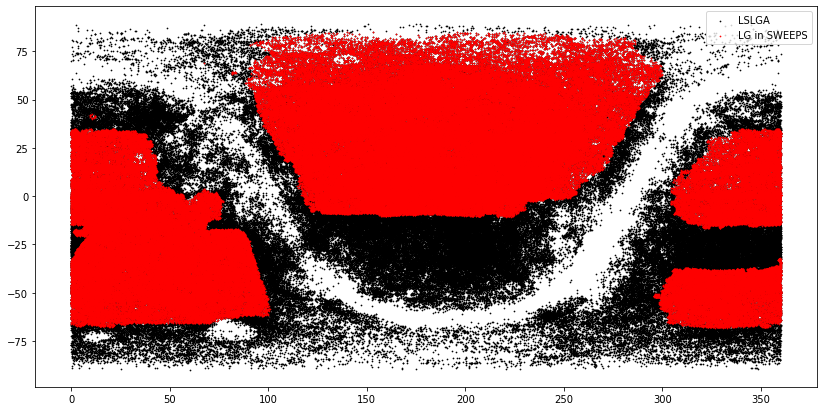

In [8]:
plt.figure(figsize=(14, 7))
plt.scatter(lslga['RA'], lslga['DEC'], s=.5, c='k', label='LSLGA')
plt.scatter(mbs['RA'][LG], mbs['DEC'][LG], s=.5, c='r', label='LG in SWEEPS')

plt.legend()

## Match LG in SWEEPS with LSLGA-V2

In [9]:
# matching LS8 with gama galaxies
idx2, idx1, d2d, d_ra, d_dec = search_around(lg['RA'], lg['DEC'], lslga['RA'], lslga['DEC'], search_radius=5)

291602 nearby objects


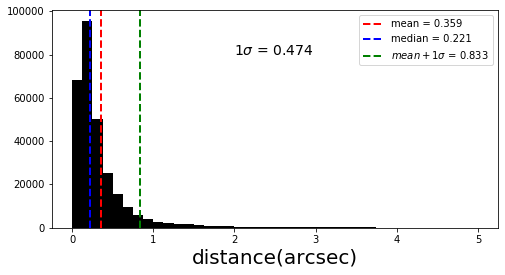

In [10]:
plt.figure(figsize=(8, 4))
plt.hist(d2d, 40, color='k')

std1 = np.std(d2d)
mean = np.mean(d2d)
median = np.median(d2d)

plt.axvline(mean, ls='--', c='r', lw=2, label='mean = %.3f' %(mean))
plt.axvline(median, ls='--', c='b', lw=2, label='median = %.3f' %(median))
plt.axvline(mean+1*std1, ls='--', c='green', lw=2, label=r'$mean+1\sigma$ = %.3f' %(mean+1*std1))
plt.text(2, 80000, r'$1\sigma$ = %.3f' %(std1), size=14)
plt.xlabel(r'distance(arcsec)', size=20)
plt.legend()
plt.show()

In [11]:
def inLSLGA(df=None, lslga=None, lslgamask=None, sr=1):
    '''
    Match BGS cat with LSLGA
    
    Inputs:
    -------
    MASK: array:boolean:: Boolen array with LSLGA size
    
    Returns:
    -------
    idx1: array: int:: BGS Index array of matched objects
    radius_LG: 3D-array: float:: BGS array-like (same lenght as BGS) of LSLGA semi-major, semi-minor and angle params
    '''
    
    if lslgamask is None:
        lslgamask = np.ones(len(lslga), bool)
        
    idx2, idx1, d2d, d_ra, d_dec = search_around(lslga['RA'][lslgamask], lslga['DEC'][lslgamask], df['RA'], 
                                             df['DEC'], search_radius=sr)
    
    major = np.zeros(len(df), float)
    minor = np.zeros(len(df), float)
    angle = np.zeros(len(df), float)

    major[idx1] = lslga['D25'][lslgamask][idx2]/2./60.
    minor[idx1] = major[idx1]*lslga[lslgamask]['BA'][idx2]
    angle[idx1] = 90 - lslga['PA'][lslgamask][idx2]
    
    radius_LG = np.array([major, minor, angle]).T
    
    return idx1, radius_LG

## Sanity check of our visual LG elliptical masking
In DR8, the LG maskbits use the LSLGA-V2 catalogue to define their elliptical masK:

    * D25: major axis
    * BA: minor axis
    * PA: angle
    
NOTE: postage images need the semi-major and semi-minor axis in degrees as input.

In [12]:
from io_ import get_sweep_whole
from postages_images import postages_circle

In [13]:
#get SWEEP objects from G12 GAMA field
def gama12():
    
    return [174., 186., -3., 2.]

g12 =  get_sweep_whole(patch=gama12(), dr='dr8-south', rlimit=None, maskbitsource=False, bgsbits=True, opt='1')

sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr8-south_sweep_174.0_186.0_-3.0_2.0.npy
Total run time: 0.000937 sec


In [14]:
inLG = ((g12['MASKBITS']) & (2**12)) != 0
outLG = ((g12['MASKBITS']) & (2**12)) == 0

Progress...N/A%|                                                    |

56 nearby objects


Progress...100%|####################################################|


Colour key:
	 inLG --> lime
	 outLG --> royalblue
	 other --> red


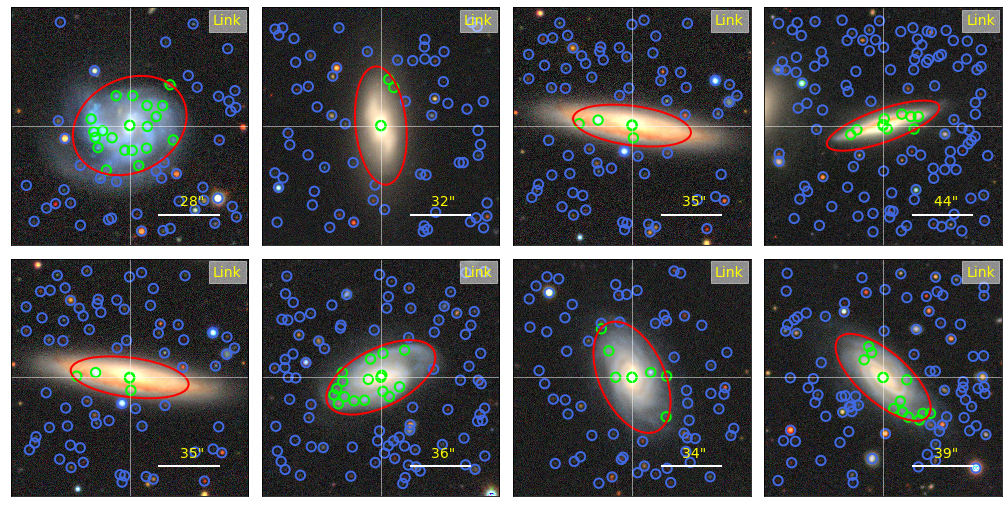

In [15]:
#get index of LSLGA in DECam
lslgamask = (lslga['MAG'] < 15) & (lslga['MAG'] > 14)
LG_idx1, radius_LG = inLSLGA(df=g12, lslga=lslga, lslgamask=lslgamask, sr=1)

#Get the postages...
veto = {'inLG':inLG, 'outLG':outLG}
#info = {'r':rmag,'M':mask_lab, '':df['TYPE']}
layer = 'dr8'

#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[g12['RA'], g12['DEC']], centeridx=LG_idx1, veto=veto, info=None, scale=0.262, 
                scale_unit='pixscale', layer=layer, radius=radius_LG, m=2, grid=[2,4], 
                    savefile='%s/sources_in_out_LG' %(pathdir), layer2=None, layer2Mode=None, 
                        isLG=True, title=None, markers=False, colorkey=True)


## Get SWEEPS LG semi-major and semi-minor axis from LSLGA-V2 catalogue



In [16]:
lg_idx1, radius_lg = inLSLGA(df=lg, lslga=lslga, lslgamask=None, sr=1)

274626 nearby objects


In [17]:
#get rid of semi-major and semi-minor axis with values of 0
semimajor = radius_lg[:, 0]*3600
semiminor = radius_lg[:, 1]*3600
angle = radius_lg[:, 2]
keep = (semimajor > 0) & (semiminor > 0)

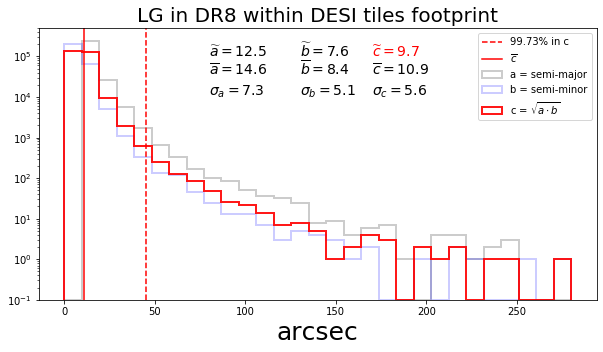

In [18]:
fig = plt.figure(figsize=(10, 5))
lim2 = np.percentile(semimajor[keep], (0, 99.9))
lim = np.percentile(semiminor[keep], (0, 100))
#print(lim2)

bins = np.linspace(0, 280, 30)

c = np.sqrt(semiminor[keep]*semimajor[keep])

median_a = np.median(semimajor[(keep)])
mean_a = np.mean(semimajor[(keep)])
std_a = np.std(semimajor[keep])

median_b = np.median(semiminor[(keep)])
mean_b = np.mean(semiminor[(keep)])
std_b = np.std(semiminor[keep])

median_c = np.median(c)
mean_c = np.mean(c)
std_c = np.std(c)

plt.hist(semimajor[keep], bins=bins, color='k', log=True, histtype='step', lw=2, alpha=0.2, label='a = semi-major')
plt.hist(semiminor[keep], bins=bins, color='b', log=True, histtype='step', lw=2, alpha=0.2, label='b = semi-minor')
plt.hist(c, bins=bins, color='r', log=True, histtype='step', lw=2, alpha=0.9, label=r'c = $\sqrt{a\cdot b}$')
#plt.axvline(np.percentile(semimajor[keep], 99.73), ls='--', c='k', alpha=0.6, label='99.73% in a')
#plt.axvline(np.percentile(semiminor[keep], 99.73), ls='--', c='b', alpha=0.6, label='99.73% in b')
plt.axvline(np.percentile(c, 99.73), ls='--', c='r', label='99.73% in c')

plt.text(80, 10**5, r'$\widetilde{a}=%.1f$' %(median_a), size=14, color='k')
plt.text(80, 10**5/3, r'$\overline{a}=%.1f$' %(mean_a), size=14, color='k')
plt.text(80, 10**5/9, r'$\sigma_{a}=%.1f$' %(std_a), size=14, color='k')

plt.text(130, 10**5, r'$\widetilde{b}=%.1f$' %(median_b), size=14, color='b')
plt.text(130, 10**5/3, r'$\overline{b}=%.1f$' %(mean_b), size=14, color='b')
plt.text(130, 10**5/9, r'$\sigma_{b}=%.1f$' %(std_b), size=14, color='b')

plt.text(170, 10**5, r'$\widetilde{c}=%.1f$' %(median_c), size=14, color='r')
plt.text(170, 10**5/3, r'$\overline{c}=%.1f$' %(mean_c), size=14, color='r')
plt.text(170, 10**5/9, r'$\sigma_{c}=%.1f$' %(std_c), size=14, color='r')

#plt.axvline(mean_a, c='k', ls='-', alpha=0.6, label=r'$\overline{a}$')
#plt.axvline(mean_b, c='b', ls='-', alpha=0.6, label=r'$\overline{b}$')
plt.axvline(mean_c, c='r', ls='-', label=r'$\overline{c}$')

plt.title(r'LG in DR8 within DESI tiles footprint', size=20)
plt.xlabel(r'arcsec', size=25)

plt.legend()

file = pathdir+'/LSLGA_major_minor_desi_footprint'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

I took the LSLGA catalogue within the DESI tiles footprint (~14000 deg^2 area) and plot the distribution of the semi-major (a) and semi-minor (b) axis which are defined by the D25 and BA parameters:

a = D25/2,
b = (D25/2) * BA,

where:

D25: "best" diameter estimate [arcmin],
BA: homogenized minor-to-major axis ratio.

The "a" and "b" number counts are plotted on figure "LSLGA_major_minor_desi_footprint.png". The median for "a" is at 12.5 arcsec and for "b" at 7.6 arcsec. These values are represented in the solid vertical lines. The dashed vertical lines show percentiles at 99.73%. I've also included the mean and the standard deviation values in the figure.

Regarding the redshifts, these do come in the LSLGA catalogue. Figure "LSLGA_z_desi_footprint.png" shows the redshift distribution for these objects. The median is at z=0.22 where the distribution peaks. Percentiles at 99.73% and 99% are shown in green dashed line and blue dashed line respectively. 

To compare redshifts between LSLGA and BGS galaxies with 15 < rmag < 16 (BGS_VB) (i.e., the differences between solid and dashed-dotted curves in Pauline's plot), I match BGS_VB with GAMA Main sample only for the G12 field, lets called this matched sample BGS_VB_matched. BGS_VB_matched have 98% completeness with respect to BGS_VB (#BGS_VB_matched/#BGS_VB = 0.98). The LSLGA sample, to be compared with BGS_VB_matched, was defined taking only LSLGA objects within the G12 footprint. Redshifts from this sample where taken from the LSLGA catalogue, different from sample BGS_VB_matched that takes redshifts from GAMA main sample. Redshift distributions of these two samples are in figure "LSLGA_BGS_VB_matched_z_g12.png". The median is the same for both samples at z=0.08. Both samples look similar in shape for z>0.08 but for z<0.08 the LSLGA sample present a secon peak at very low redshifts.


In [23]:
# matching LS8 with gama galaxies
#idx2, idx1, d2d, d_ra, d_dec = search_around(lg['RA'], lg['DEC'], lslga['RA'], lslga['DEC'], search_radius=1)

274626 nearby objects


In [24]:
#lslga_z = lslga['Z'][idx1]
#keep = ~np.isnan(lslga_z)

In [38]:
from io_ import get_isdesi

lslga_desi = get_isdesi(ra=lslga['RA'], dec=lslga['DEC'])
lslga_z = lslga['Z'][lslga_desi]
keep = ~np.isnan(lslga_z)

In [44]:
print('completeness LSLGA with redshifts/all LSLGA: \t %i / %i = %.3f' %(np.sum(keep), len(lslga_z), np.sum(keep)/len(lslga_z)))

completeness LSLGA with redshifts/all LSLGA: 	 223122 / 280746 = 0.795


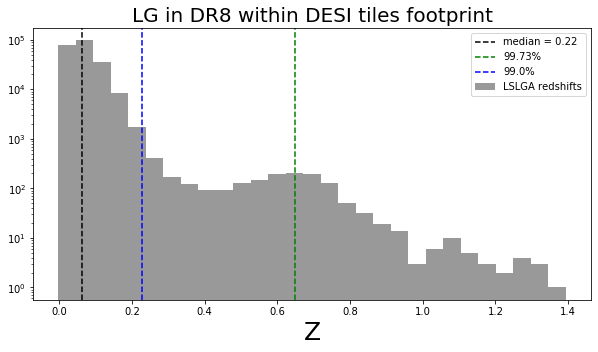

In [46]:
#
fig = plt.figure(figsize=(10, 5))

lim = np.percentile(lslga_z[keep], (0, 99.99))
bins = np.linspace(lim[0], lim[1], 30)

meadian = np.median(lslga_z[keep])

#plt.hist(lslga['Z'][(~np.isnan(lslga['Z']))], bins=bins, log=True, color='k', alpha=0.4, label='LSLGA redshifts ALL')
plt.hist(lslga_z[keep], bins=bins, log=True, color='k', alpha=0.4, label='LSLGA redshifts')
plt.axvline(meadian, ls='--', color='k', label='median = %.2f' %(median))
plt.axvline(np.percentile(lslga_z[keep], 99.73), ls='--', c='g', label='99.73%')
plt.axvline(np.percentile(lslga_z[keep], 99.0), ls='--', c='b', label='99.0%')

plt.xlabel(r'Z', size=25)
plt.title(r'LG in DR8 within DESI tiles footprint', size=20)
plt.legend()

file = pathdir+'/LSLGA_z_desi_footprint'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

## Compare LG redshifts with BGS between 15 < r < 16 using redshifts from GAMA

* LG sample: LSLGA redshifts within G12 footprint
* BGS sample: GAMA redshifts of BGS within 15 < r < 16 ($bgs_{VB}$) matched with GAMA ($bgs_{VB}^{gama}$). Get the fraction $f = bgs_{VB}^{gama}/bgs_{VB}$. Do we have a high completeness at those magnitudes (i.e., $f$ close to 1)?


In [21]:
#reeduce LSLGA to G12 footprint
ing12 = (lslga['RA'] > gama12()[0]) & (lslga['RA'] < gama12()[1]) & (lslga['DEC'] > gama12()[2]) & (lslga['DEC'] < gama12()[3])
lslga_g12 = lslga[ing12]

#get BGS sample within 15 < rmag < 16
bgs = ((g12['BGSBITS'] & 2**(20)) != 0)
bgsVB = g12[(bgs) & (g12['RMAG'] > 15) & (g12['RMAG'] < 16)]

In [22]:
#load GAMA
gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

fraction of gama good quality: 186137 / 221373


In [23]:
# matching bgs within 15 < r < 16 with gama
idx2, idx1, d2d, d_ra, d_dec = search_around(bgsVB['RA'], bgsVB['DEC'], gama['RA'], gama['DEC'], search_radius=1)


561 nearby objects


In [24]:
print('N in LSLGA within G12: %i' %(len(lslga_g12)))
print('N BGS within 15 < r < 16 and within G12: %i' %(len(bgsVB)))
print('N BGS within 15 < r < 16, within G12 and matched with GAMA: %i' %(len(bgsVB[idx2])))
print('fraction of bgsVB matched with GAMA out of total in bgsVB: f=%.2f' %(len(bgsVB[idx2])/len(bgsVB)))

N in LSLGA within G12: 1426
N BGS within 15 < r < 16 and within G12: 575
N BGS within 15 < r < 16, within G12 and matched with GAMA: 561
fraction of bgsVB matched with GAMA out of total in bgsVB: f=0.98


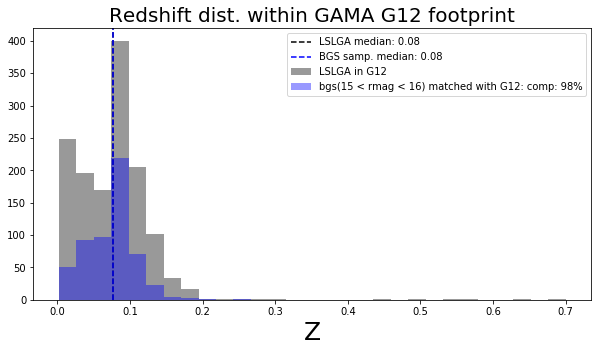

In [25]:
#
fig = plt.figure(figsize=(10, 5))
log = False

lslga_nan = ~np.isnan(lslga_g12['Z'])
lim = np.percentile(lslga_g12['Z'][lslga_nan], (0, 100))
bins = np.linspace(lim[0], lim[1], 30)

plt.hist(lslga_g12['Z'][lslga_nan], bins=bins, log=log, color='k', alpha=0.4, label=r'LSLGA in G12')
plt.hist(gama['Z'][idx1], bins=bins, log=log, color='b', alpha=0.4, label=r'bgs(15 < rmag < 16) matched with G12: comp: 98%')

median_lslga = np.median(lslga_g12['Z'][lslga_nan])
plt.axvline(median_lslga, ls='--', color='k', label=r'LSLGA median: %.2f' %(median_lslga))
median_bgs = np.median(gama['Z'][idx1])
plt.axvline(median_bgs, ls='--', color='b', label=r'BGS samp. median: %.2f' %(median_bgs))

plt.xlabel(r'Z', size=25)
plt.title(r'Redshift dist. within GAMA G12 footprint', size=20)
plt.legend()

file = pathdir+'/LSLGA_BGS_VB_matched_z_g12'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)